We can clearly see that calculating correlation in spatial domain is unable to detect similarities in a meaningful way, that's why it is necessary to move to frequency domain and calculate phase correlation.

36 450 800


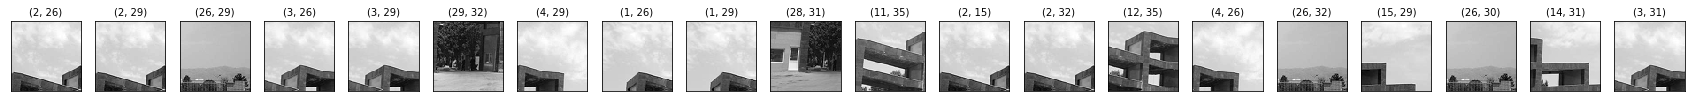

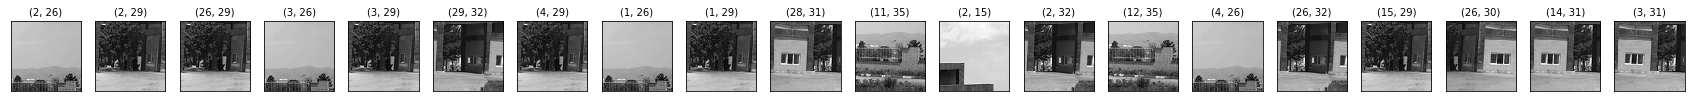

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
from PIL import Image


# Load image
fimg = Image.open("fimg.jpg").convert('L')
fimg = np.array(fimg)

#let's break the image into multiple windows of size N moved N/2 each time
windows = []
N = 155
for i in range(0, fimg.shape[0], N//2):
    for j in range(0, fimg.shape[1], N//2):
        if (i + N) <= fimg.shape[0] and (j + N) <= fimg.shape[1]:
            windows.append(((i, i+N), (j, j+N), fimg[i:i+N, j:j+N]))
            
print(len(windows), fimg.shape[0], fimg.shape[1])

approximations_of_windows = []

for img in windows:
    coeffs2 = pywt.dwt2(img[2], 'bior1.3')
    LL, (_, _, _) = coeffs2
    approximations_of_windows.append((img[0], img[1], LL))

correlation_coef = []
for i in range(len(approximations_of_windows)):
    for j in range(i + 1, len(approximations_of_windows)):
        if not ((approximations_of_windows[i][0][0] <= approximations_of_windows[j][0][0] <= approximations_of_windows[i][0][1]) and
            (approximations_of_windows[i][1][0] <= approximations_of_windows[j][1][0] <= approximations_of_windows[i][1][1])):
            correlation_coef.append((i, j, np.absolute(np.corrcoef(approximations_of_windows[i][2].flat, approximations_of_windows[j][2].flat)[0, 1])))

correlation_coef = list(reversed(sorted(correlation_coef, key=lambda x: (x[2], x[0], x[1]))))

fig1 = plt.figure(figsize=(30, 30))
fig2 = plt.figure(figsize=(30, 30))

t = correlation_coef[:20]
for i in range(len(t)):
    ax = fig1.add_subplot(1, len(t), (i) + 1)
    ax.imshow(approximations_of_windows[t[i][0]][2], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(str(t[i][:2]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig2.add_subplot(1, len(t), (i) + 1)
    ax.imshow(approximations_of_windows[t[i][1]][2], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(str(t[i][:2]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])



# fig1.tight_layout()
# fig2.tight_layout()

plt.show()

Here we implement phase correlation, acording to this wikipedia page this is how we should calculate it:
https://en.wikipedia.org/wiki/Phase_correlation

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image

In [19]:
def break_into_overlapping_windows(N, img, r=3):
    windows = []
    for i in range(0, img.shape[0], N//r):
        for j in range(0, img.shape[1], N//r):
            if (i + N) <= img.shape[0] and (j + N) <= img.shape[1]:
                windows.append(((i, i+N), (j, j+N), img[i:i+N, j:j+N]))
    return windows

In [20]:
def approximate_windows(windows):
    approximations_of_windows = []

    for img in windows:
        coeffs2 = pywt.dwt2(img[2], 'bior1.3')
        LL, (_, _, _) = coeffs2
        approximations_of_windows.append((img[0], img[1], LL))   
    return approximations_of_windows

In [21]:
def single_phase_corr(similar1, similar2):
    cross_power_spectrum = np.multiply(np.fft.fft2(similar1), np.fft.fft2(similar2).conjugate())
    R_ij = cross_power_spectrum / np.absolute(cross_power_spectrum)
    r = np.fft.ifft2(R_ij)
    return r

In [22]:
def calc_windows_phase_corr(approximations_of_windows):
    correlation_coef = []
    for i in range(len(approximations_of_windows)):
        for j in range(i + 1, len(approximations_of_windows)):
            if not ((approximations_of_windows[i][0][0] <= approximations_of_windows[j][0][0] <= approximations_of_windows[i][0][1]) and
                (approximations_of_windows[i][1][0] <= approximations_of_windows[j][1][0] <= approximations_of_windows[i][1][1])):
                temp = single_phase_corr(approximations_of_windows[i][2], approximations_of_windows[j][2]).real
                max_val = np.unravel_index(temp.argmax(), temp.shape)
                max_val = temp[max_val[0], max_val[1]]
                correlation_coef.append((i, j, max_val))
    return correlation_coef

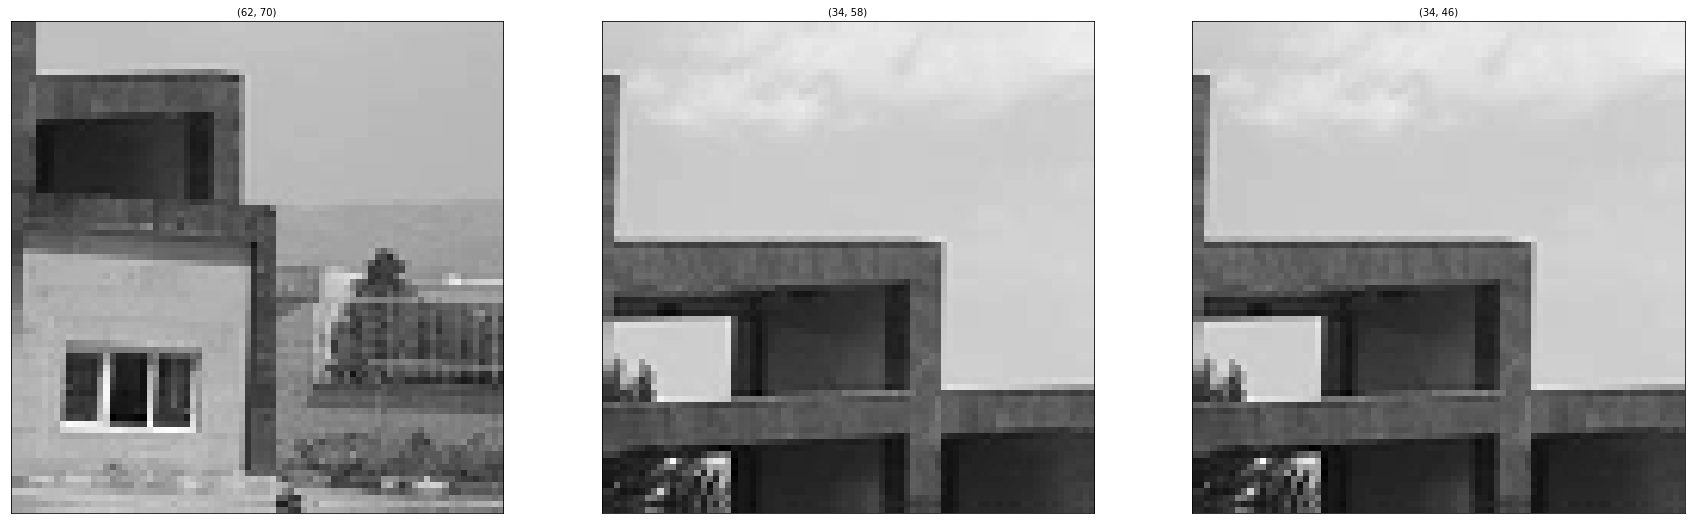

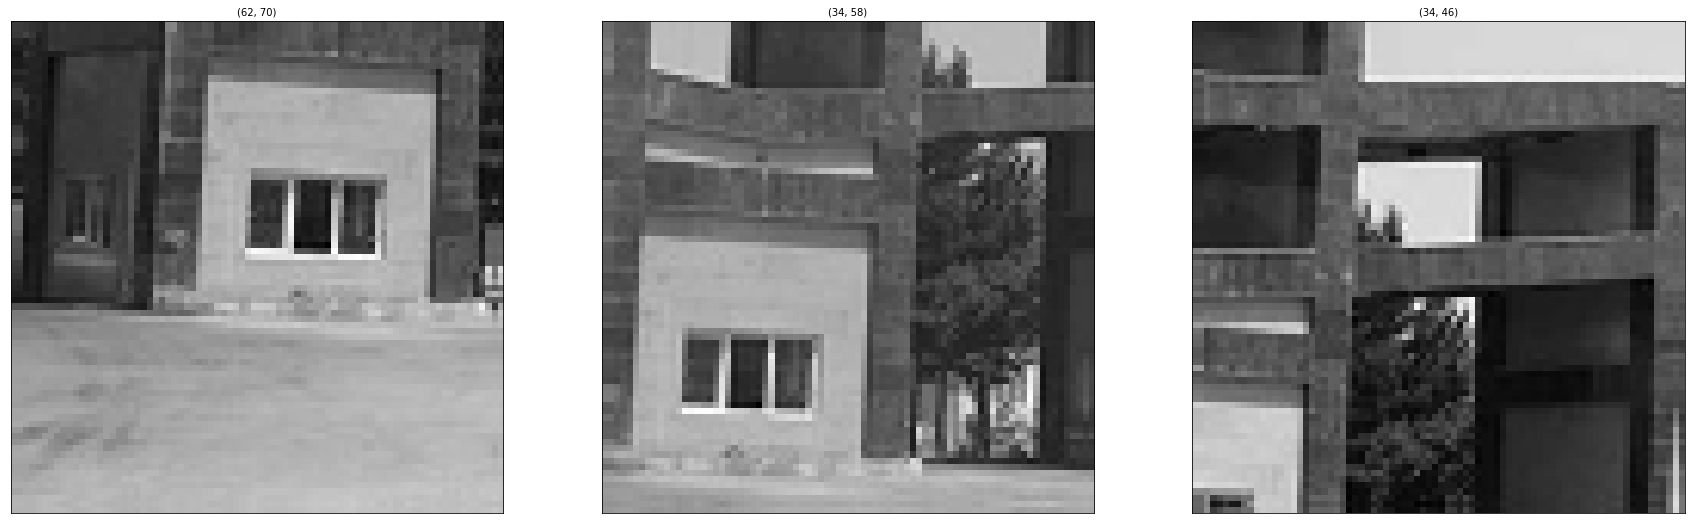

In [11]:
fimg = Image.open("fimg.jpg").convert('L')
fimg = np.array(fimg)

windows = break_into_overlapping_windows(155, fimg)

approximations_of_windows = approximate_windows(windows)

correlation_coef = calc_windows_phase_corr(approximations_of_windows)
correlation_coef = list(reversed(sorted(correlation_coef, key=lambda x: (x[2], x[0], x[1]))))


fig1 = plt.figure(figsize=(30, 30))
fig2 = plt.figure(figsize=(30, 30))

t = correlation_coef[:3]
for i in range(len(t)):
    ax = fig2.add_subplot(1, len(t), (i) + 1)
    ax.imshow(approximations_of_windows[t[i][1]][2], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(str(t[i][:2]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig1.add_subplot(1, len(t), (i) + 1)
    ax.imshow(approximations_of_windows[t[i][0]][2], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(str(t[i][:2]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])


plt.show()

In [23]:
def calc_windows_phase_corr_precise(approximations_of_windows1, approximations_of_windows2):
    correlation_coef = []
    for i in range(len(approximations_of_windows1)):
        for j in range(len(approximations_of_windows2)):
            temp = single_phase_corr(approximations_of_windows1[i][2], approximations_of_windows2[j][2]).real
            max_val = np.unravel_index(temp.argmax(), temp.shape)
            max_val = temp[max_val[0], max_val[1]]
            correlation_coef.append((i, j, max_val))
    return correlation_coef

((204, 358), (510, 664)) ((58, 131), (0, 73)) ((255, 409), (255, 409)) ((15, 87), (58, 131))


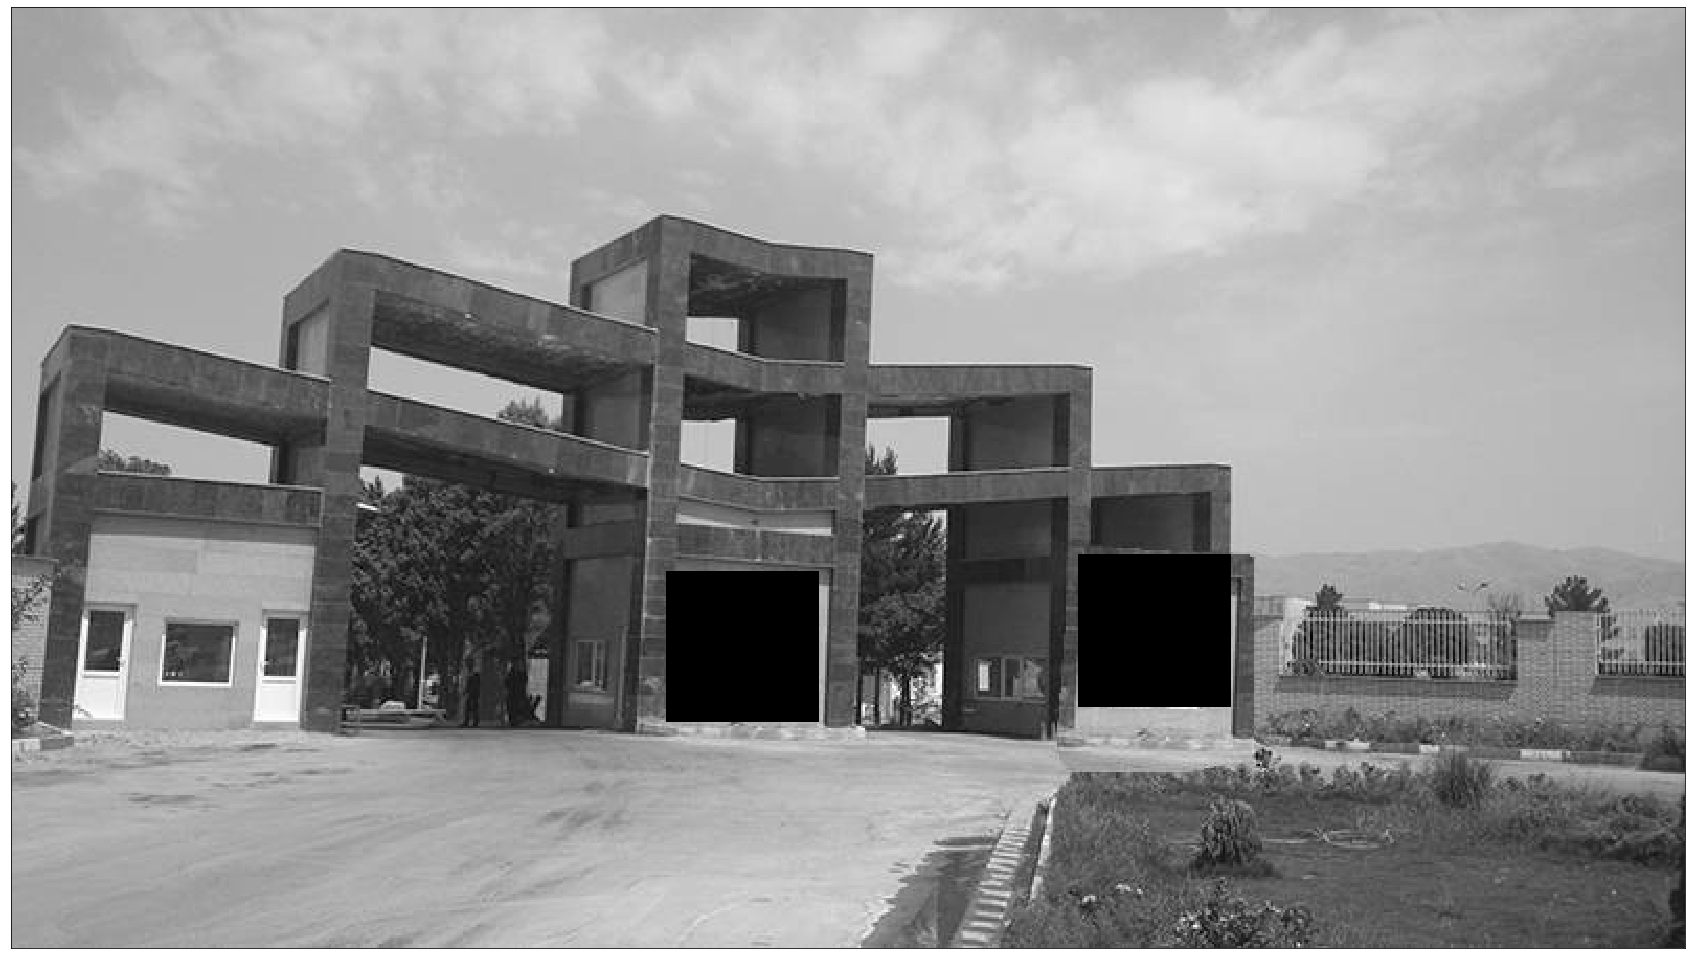

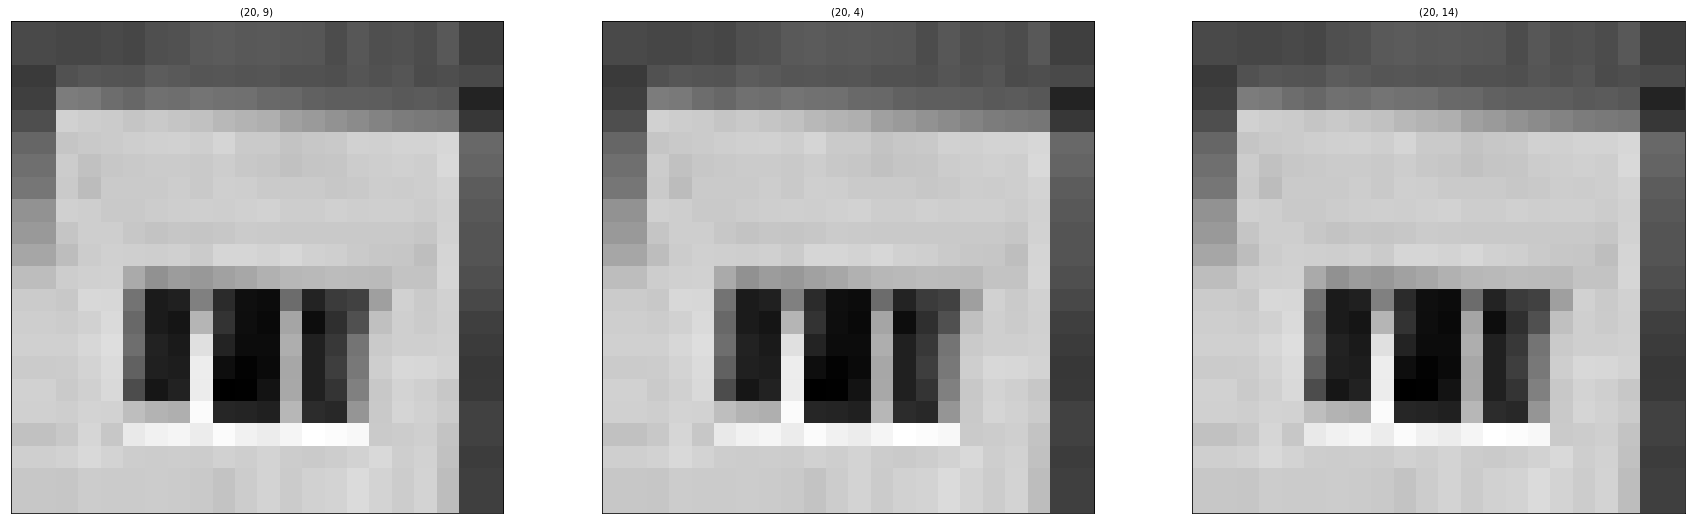

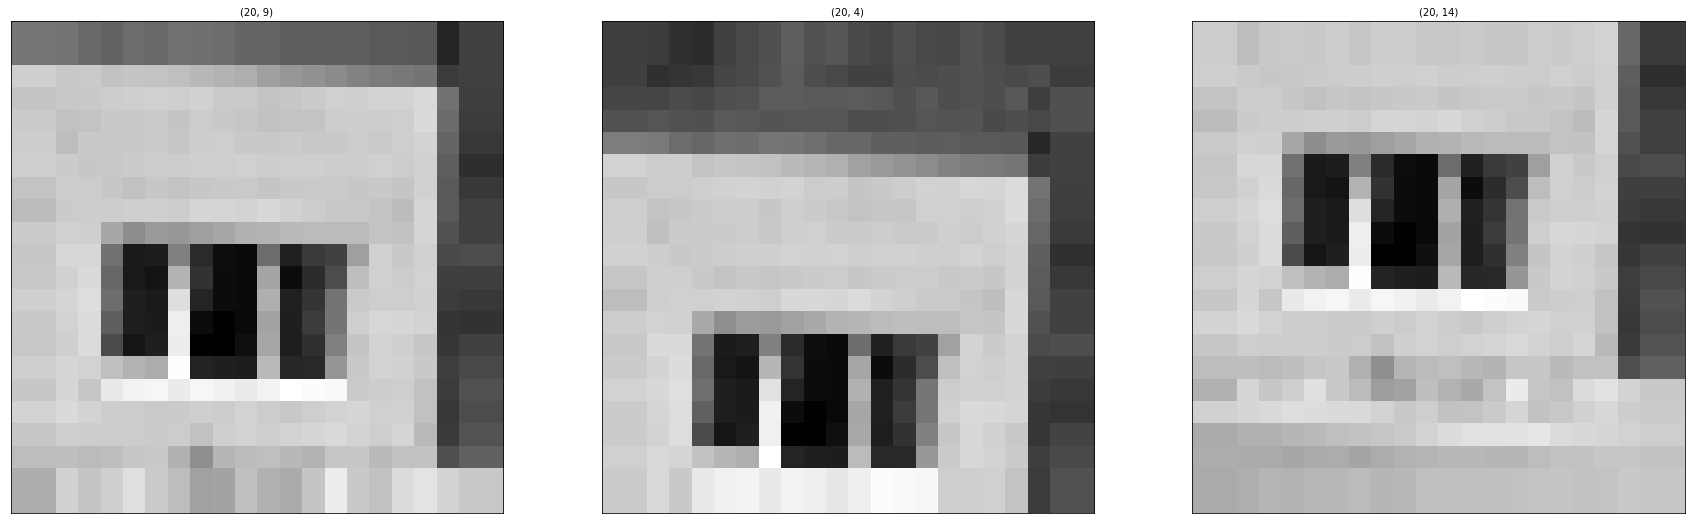

In [31]:
fimg = Image.open("fimg.jpg").convert('L')
fimg = np.array(fimg)

windows = break_into_overlapping_windows(154, fimg)

approximations_of_windows = approximate_windows(windows)

correlation_coef = calc_windows_phase_corr(approximations_of_windows)
correlation_coef = list(reversed(sorted(correlation_coef, key=lambda x: (x[2], x[0], x[1]))))

t = correlation_coef[0]
a1 = (approximations_of_windows[t[0]][:2])
b1 = (approximations_of_windows[t[1]][:2])

fimg1 = approximations_of_windows[t[0]][2]
fimg2 = approximations_of_windows[t[1]][2]

windows1 = break_into_overlapping_windows(40, fimg1, 5)
approximations_of_windows1 = approximate_windows(windows1)
size_of_approx = windows1[0][2].shape

windows2 = break_into_overlapping_windows(40, fimg2, 5)
approximations_of_windows2 = approximate_windows(windows2)

correlation_coef = calc_windows_phase_corr_precise(approximations_of_windows1, approximations_of_windows2)
correlation_coef = list(reversed(sorted(correlation_coef, key=lambda x: (x[2], x[0], x[1]))))
t = correlation_coef[0]
size_of_approx_2 = approximations_of_windows1[t[0]][2].shape

ratio = size_of_approx[0] / size_of_approx_2[0]

a2 = (approximations_of_windows1[t[0]][:2])
a2 = ((round(a2[0][0] * ratio), round(a2[0][1] * ratio)), (round(a2[1][0] * ratio), round(a2[1][1] * ratio)))
b2 = (approximations_of_windows2[t[1]][:2])
b2 = ((round(b2[0][0] * ratio), round(b2[0][1] * ratio)), (round(b2[1][0] * ratio), round(b2[1][1] * ratio)))

print(a1, a2, b1, b2)
pos1 = ((a1[0][0] + a2[0][0], a1[0][0] + a2[0][1]), ((a1[1][0] + a2[1][0], a1[1][0] + a2[1][1])))
pos2 = ((b1[0][0] + b2[0][0], b1[0][0] + b2[0][1]), ((b1[1][0] + b2[1][0], b1[1][0] + b2[1][1])))
        
for i in range(pos1[0][0], pos1[0][1]):
    for j in range(pos1[1][0], pos1[1][1]):
        fimg[i, j] = 0
for i in range(pos2[0][0], pos2[0][1]):
    for j in range(pos2[1][0], pos2[1][1]):
        fimg[i, j] = 0

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(fimg, interpolation="nearest", cmap=plt.cm.gray)
ax.set_xticks([])
ax.set_yticks([])

fig1 = plt.figure(figsize=(30, 30))
fig2 = plt.figure(figsize=(30, 30))

t = correlation_coef[:3]
for i in range(len(t)):
    ax = fig1.add_subplot(1, len(t), (i) + 1)
    ax.imshow(approximations_of_windows1[t[i][0]][2], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(str(t[i][:2]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig2.add_subplot(1, len(t), (i) + 1)
    ax.imshow(approximations_of_windows2[t[i][1]][2], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(str(t[i][:2]), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])


Now we write code for 6.3, first functions for adding noise and then for reducing it

In [24]:
def add_gaussian_noise(image, mean=0, variance=20, ratio=1):
    row,col = image.shape
    sigma = variance ** ratio
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    noisy *= 255.0 / noisy.max() 
    noisy = np.clip(noisy, 0, 255)
    return noisy

In [25]:
def add_salt_and_paper_noise(image, salt_ratio_paper=0.5, amount=0.004):
    row, col = image.shape
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * salt_ratio_paper)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[tuple(coords)] = 1

    # Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - salt_ratio_paper))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[tuple(coords)] = 0
    out = np.clip(out, 0, 255)
    return out

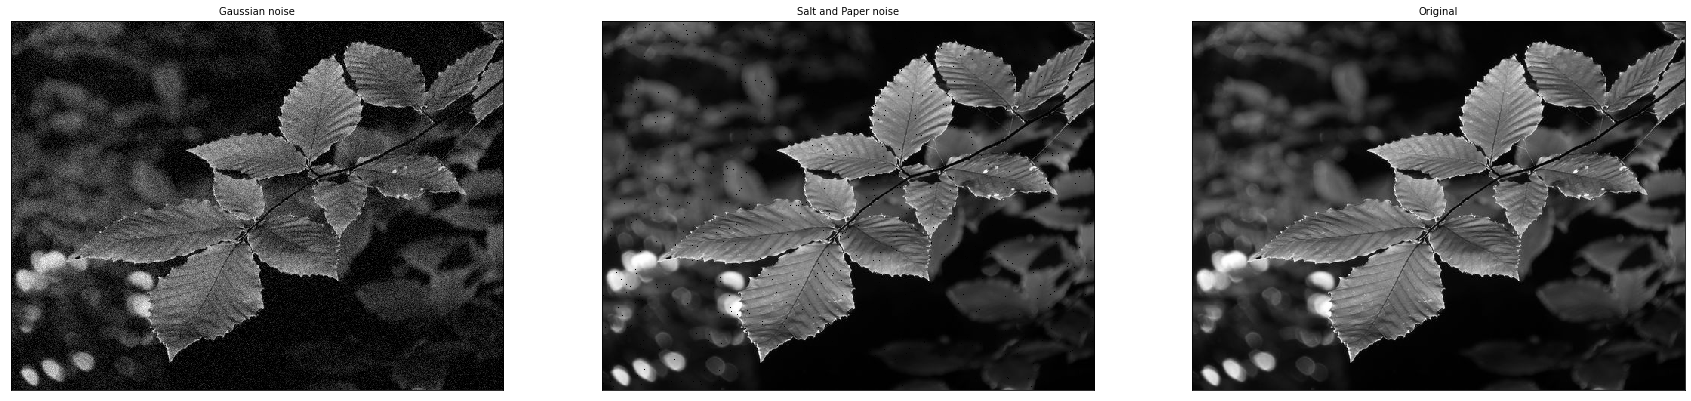

In [26]:
tree = Image.open("tree.jpg").convert('L')
tree = np.array(tree)

tree_gaussian = add_gaussian_noise(tree)
tree_salty = add_salt_and_paper_noise(tree)

fig = plt.figure(figsize=(30, 30))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(tree_gaussian.astype(int),interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Gaussian noise", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(tree_salty.astype(int), interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Salt and Paper noise", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(tree.astype(int), interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Original", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])


plt.show()

    SSIM     PSNR  TYPE          threshold  sigma    ratio    amount
--------  -------  ----------  -----------  -------  -------  --------
0.296463  345.946  Gaussian             18  20       -        -
0.737405  356.64   Salt&Paper            5  -        0.5      0.004


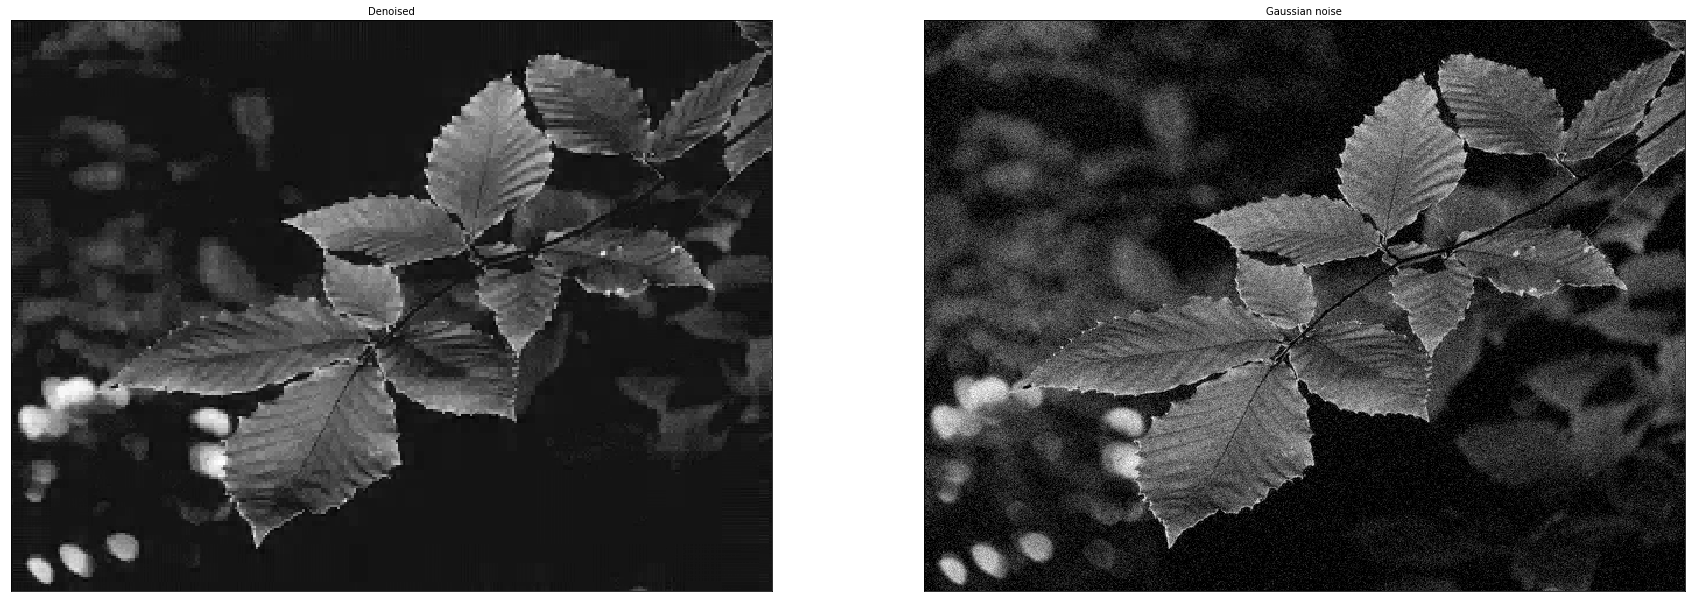

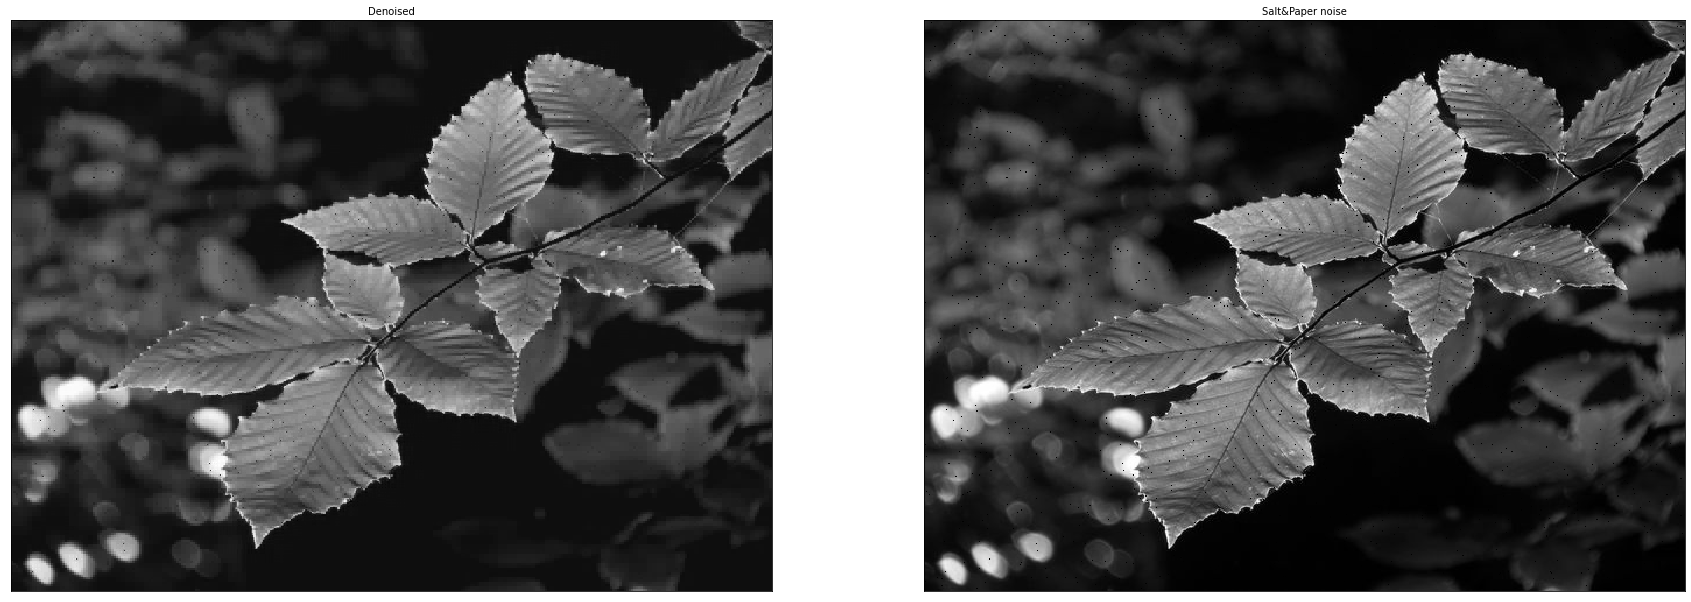

In [30]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tabulate import tabulate
wp = pywt.WaveletPacket2D(data=tree_gaussian, wavelet='bior1.3')



types = ['a', 'h', 'v', 'd']
coefs = {}
for d in range(0, 6):
    for i in range(4):
        key_word = types[i] * d
        for j in range(4):
            key_word_inner = key_word + types[j]
            if len(key_word_inner) > 6:
                continue
            wp[key_word_inner].data = pywt.threshold(wp[key_word_inner].data, 18, 'soft')

    
a = wp.reconstruct(update=False)

fig = plt.figure(figsize=(30, 30))

ax = fig.add_subplot(1, 2,1)
ax.imshow(a.astype(int),interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Denoised", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 2,2)
ax.imshow(tree_gaussian.astype(int),interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Gaussian noise", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

tree_gaussian_ssim = ssim(tree, a, data_range=a.max() - a.min())
tree_gaussian_psnr = psnr(tree.astype(int), a.astype(int))

wp = pywt.WaveletPacket2D(data=tree_salty, wavelet='bior1.3')



types = ['a', 'h', 'v', 'd']
coefs = {}
for d in range(0, 6):
    for i in range(4):
        key_word = types[i] * d
        for j in range(4):
            key_word_inner = key_word + types[j]
            if len(key_word_inner) > 6:
                continue
            wp[key_word_inner].data = pywt.threshold(wp[key_word_inner].data, 5, 'soft')

    
a = wp.reconstruct(update=False)


fig = plt.figure(figsize=(30, 30))

ax = fig.add_subplot(1, 2,1)
ax.imshow(a.astype(int),interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Denoised", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 2,2)
ax.imshow(tree_salty.astype(int),interpolation="nearest", cmap=plt.cm.gray)
ax.set_title("Salt&Paper noise", fontsize=10)
ax.set_xticks([])
ax.set_yticks([])


tree_salt_and_paper_ssim = ssim(tree, a, data_range=a.max() - a.min())
tree_salt_and_paper_psnr = psnr(tree.astype(int), a.astype(int))

result = []
result.append([tree_gaussian_ssim, tree_gaussian_psnr, "Gaussian", 18, 20,"-", "-"])
result.append([tree_salt_and_paper_ssim, tree_salt_and_paper_psnr, "Salt&Paper", 5, "-", 0.5, 0.004])

print(tabulate(result, headers=['SSIM', 'PSNR', 'TYPE', "threshold", 'sigma', "ratio", "amount"]))
